In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from lib import load_data
import seaborn as sns
%matplotlib inline

In [4]:
users_df, costs_df, relations_df, visits_df, orders_df = load_data()

### Задание №2:
### 1. Рассчитать для показателей Retention (процент вернувшихся пользователей на сайт) целевые lifetimes в разрезе маркетинговых источников.

In [5]:
print('Users registrations slice: {} -- {}'.format(
    users_df['Reg_date'].max().strftime('%Y-%m-%d'), 
    users_df['Reg_date'].min().strftime('%Y-%m-%d')))

Users registrations slice: 2017-12-31 -- 2017-06-01


#### Limit lifetimes to 30 days

In [6]:
lifetime_days_limit = 30
mask = users_df['Reg_date'] < (users_df['Reg_date'] - np.timedelta64(lifetime_days_limit, 'D'))
users_df.drop(users_df.index[mask], inplace=True)

#### Join the tables

In [7]:
users_df = users_df.merge(relations_df, how='inner', on=['name', 'id_partner'])

In [8]:
visits_df = visits_df.merge(users_df[['Reg_date','chanel','id']], 
                            how='right', left_on='id_user', right_on='id')

#### Find how many days passed till visit since registration

In [9]:
visits_df['Visit_date'] = visits_df['Visit_date'].dt.normalize()

In [10]:
no_visits_mask = visits_df['Visit_date'].isnull()
visits_df.loc[no_visits_mask, 'Visit_date'] = visits_df.loc[no_visits_mask, 'Reg_date']

In [11]:
visits_df['day'] = visits_df['Visit_date'] - visits_df['Reg_date']

#### Drop some strange visits before registration date

In [12]:
mask = (visits_df['day'] < np.timedelta64(0, 'D'))
visits_df.drop(visits_df.index[mask], inplace=True)

In [13]:
grouped = visits_df.groupby(['chanel', 'day'])

lifetimes = grouped.agg({'id': pd.Series.nunique})
lifetimes.rename(columns={'id': 'num_users'}, inplace=True)

In [14]:
chanel_user_num = lifetimes['num_users'].groupby(level=0).first()

#### Limit to chanels with more than 200 registered users

In [23]:
chanels_with_few_users = chanel_user_num.index[chanel_user_num < 10]

In [24]:
user_retention = 100 * lifetimes['num_users'].unstack(0).divide(chanel_user_num, axis=1)
user_retention_slice = user_retention[:lifetime_days_limit+1][user_retention.columns[~user_retention.columns.isin(chanels_with_few_users)]]

In [25]:
user_retention_slice.fillna(0, inplace=True)

In [26]:
user_retention_slice.set_index(pd.Series(user_retention_slice.index).dt.days, inplace=True)

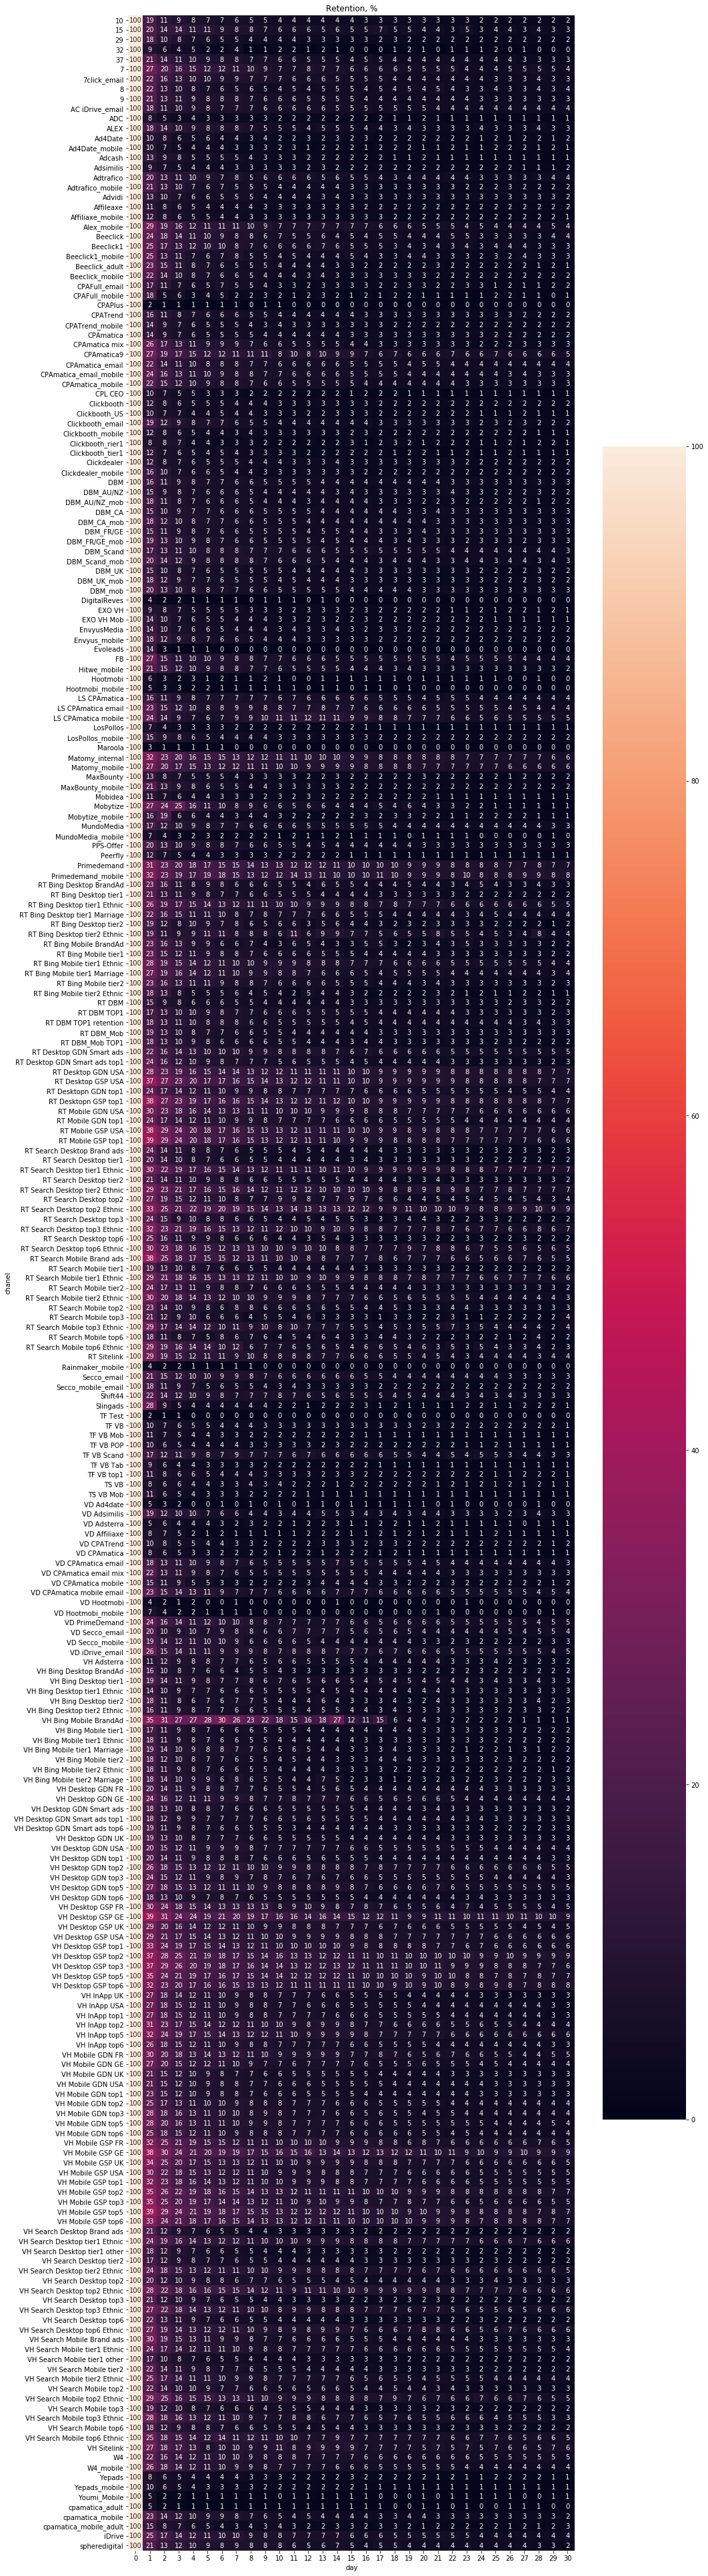

In [27]:
sns.set(style='white')
plt.figure(figsize=(15, 70))
plt.title('Retention by channels during users\' lifetime, %')
ax = sns.heatmap(user_retention_slice.T, annot=True, fmt='.0f');
ax = ax.set(xlabel='day', ylabel='chanel')
plt.show()

In [ ]:
# pd.to_datetime(user_retention_slice.index.values).dt.date
# pd.to_datetime(df['Timestamp'], format = '%Y%m%d_%H%M%S.%f')

### 2. Рассчитать для показателей Revenue (выручка) целевые lifetimes в разрезе маркетинговых источников.

In [29]:
orders_df = orders_df.merge(users_df[['Reg_date','chanel','id']], 
                            how='right', left_on='id_user', right_on='id')

In [31]:
no_orders = orders_df['Amount'].isnull()
orders_df['Order Date'] = orders_df['Order Date'].dt.normalize()
orders_df.loc[no_orders, 'Amount'] = 0
orders_df.loc[no_orders, 'Order Date'] = orders_df.loc[no_orders, 'Reg_date']
orders_df['day'] = orders_df['Order Date'] - orders_df['Reg_date']

KeyError: 'Order Date'

In [36]:
grouped = orders_df.groupby(['chanel', 'day'])

lifetimes = grouped.agg({'Amount': 'sum'})
# lifetimes.rename(columns={'id': 'num_users'}, inplace=True)
revenue_lifetimes = lifetimes['Amount'].unstack(0)
revenue_lifetimes.fillna(0, inplace=True)

chanel,10,13,14,15,29,305,309,32,34,37,...,Youmi,Youmi_Mobile,Zero,cpamatica_adult,cpamatica_mobile,cpamatica_mobile_adult,iDrive,spheredigital,vh_mgid,wefef
day,,,,,,,,,,,,,,,,,,,,,
0 days,838.2704,2.6312,0.0,0.0000,696.5816,0.0,0.0,0.0,0.0,189.0856,...,0.0,0.0,272.7736,2.6312,273.6096,17.5824,10787.7440,161.8056,0.0,0.0
1 days,1359.2216,NaN,NaN,8.7912,255.8952,NaN,NaN,NaN,NaN,924.6248,...,NaN,NaN,193.5648,NaN,70.3824,17.5912,13651.6776,65.9736,NaN,NaN
2 days,827.8952,NaN,NaN,2.6312,200.5784,NaN,NaN,NaN,NaN,456.0688,...,NaN,NaN,74.7736,NaN,131.9912,NaN,11341.2464,79.1824,NaN,NaN
3 days,970.4552,2.6312,NaN,NaN,358.9168,NaN,NaN,NaN,NaN,589.2216,...,NaN,NaN,136.3648,NaN,NaN,NaN,11274.4456,162.7384,NaN,NaN
4 days,690.7032,17.5912,NaN,NaN,871.0680,NaN,NaN,NaN,NaN,825.3080,...,NaN,NaN,140.7736,NaN,61.5912,NaN,9536.8592,109.9736,NaN,NaN
5 days,387.9832,NaN,NaN,NaN,219.9296,NaN,NaN,NaN,NaN,455.7344,...,NaN,NaN,140.7736,NaN,61.5912,NaN,10512.1632,52.7736,NaN,NaN
6 days,831.5120,NaN,NaN,8.7912,477.2944,NaN,NaN,NaN,NaN,630.3528,...,NaN,NaN,312.3560,NaN,61.5912,NaN,12695.4520,74.3424,NaN,NaN
7 days,373.9560,NaN,NaN,NaN,415.6944,NaN,NaN,NaN,NaN,743.4856,...,NaN,NaN,162.7736,NaN,61.5912,NaN,13155.7360,114.3736,NaN,NaN
8 days,747.8768,NaN,NaN,NaN,574.1032,NaN,NaN,NaN,NaN,457.5384,...,NaN,NaN,246.3648,8.7912,131.9736,NaN,9503.8064,21.9824,NaN,NaN


In [ ]:
sns.set(style='white')
plt.figure(figsize=(15, 70))
plt.title('Revenue by channels during users\' lifetime, %')
ax = sns.heatmap(user_retention_slice.T, annot=True, fmt='.0f');
ax = ax.set(xlabel='day', ylabel='chanel')
plt.show()